In [ ]:
from tqdm.notebook import tqdm
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import numpy as np
import joblib


from sim.incentive import assemble_W, assemble_S, compute_incentive
from sim.subnet_data import get_wandb_history
from sim.plotting import plot_metric, plot_multi_validator_metric, plot_incentive, plot_incentives, plot_incentive_over_time
from sim.blocks import average_challenges_per_tempo
from sim import Simulator, run_simulations

plt.rcParams['animation.embed_limit'] = 2**128

## Query W&B or Load Locally Cached Data

In [ ]:
# `load_cached_history` = True will read local pickle file at fname
# `load_cached_history` = False will query W&B
load_cached_history = True 
write_to_history_cache = True
fname = 'history_1727940981_1728176143.pkl'

#  Earlist time (epoch) from which to pull W&B runs
start_ts = 1727940981 # 1727803270  #1727846400 # 1727886242 #
end_ts = 1728176143

# Names of W&B runs to query
VALIDATOR_UIDS = [17, 20, 250, 6, 39, 19, 107, 193, 131, 122, 236, 107]
VALIDATORS = [f'validator-{uid}-1.1.0' for uid in VALIDATOR_UIDS]

# Keys will be validator names, values will be history dataframes
HISTORY_DFS = {}


In [ ]:
if load_cached_history:
    HISTORY_DFS = joblib.load(fname)
else:
    for vali in VALIDATORS:
        HISTORY_DFS[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=end_ts, 
            verbosity=2)

    if write_to_history_cache:
        joblib.dump(HISTORY_DFS, fname)


In [ ]:
format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
min_avg_challenges = 40
drop = []

for vali, history_df in HISTORY_DFS.items():
    print(vali)
    if history_df.shape[0] == 0:
        avg, counts = 0, 0
        min_ts, max_ts = 'n/a', 'n/a'
    else:
        avg, counts = average_challenges_per_tempo(history_df)
        min_ts = format_time(history_df._timestamp.min())
        max_ts = format_time(history_df._timestamp.max())
    print(f'\tDate Range: {min_ts} : {max_ts}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')
    if min_avg_challenges and min_avg_challenges > avg:
        drop.append(vali)

if min_avg_challenges and len(drop) > 0:
    print(f"Dropping {drop}")
    HISTORY_DFS = {vali: df for vali, df in HISTORY_DFS.items() if vali not in drop}
    VALIDATOR_UIDS = [int(vali.split('-')[1]) for vali in HISTORY_DFS]

print("Loaded data from validators:")
for vali in HISTORY_DFS:
    print(f"\t{vali}")

In [ ]:
limit = None  # limit history rows for quicker testing

if limit is not None:
    for v in VALIDATORS:
        HISTORY_DFS[v] = HISTORY_DFS[v].iloc[:limit]

## Run Simulation or Load Simulation Results

In [ ]:
# `load_cached_scores` = False will run simulations for each validator with the specified reward functions in parallel
# `load_cached_scores` = True will read local pickle file
load_cached_scores = False  

# `write_to_cache` = True will overwrite scored_fname
write_to_cache = True
scored_fname = f'{fname}_scored_f1.pkl' #'histories_scored_test.pkl'

# Number of dataframe rows over which to compute rewards and scores, set to `None` for all rows
score_num_challenges = None

REWARD_FNS = ['BalancedF1Reward']#GlickoReward', 'WeightedHistoryReward']'BinaryReward', 

# Keys are validator (w&b run) names, values are dataframes with reward & score columns
SCORED_DFS = {}

In [ ]:
if load_cached_scores:
    SCORED_DFS = joblib.load(scored_fname)
else:  
    SCORED_DFS = run_simulations(HISTORY_DFS, REWARD_FNS)

    if write_to_cache:
        joblib.dump(SCORED_DFS, scored_fname)

## Plot Incentive


In [ ]:
INCENTIVES = {}

for reward_cls in REWARD_FNS:
    S = assemble_S(VALIDATOR_UIDS)
    W = assemble_W(SCORED_DFS, f'weights_{reward_cls}')
    I = compute_incentive(W, S)
    INCENTIVES[reward_cls] = np.sort(I[I.nonzero()])


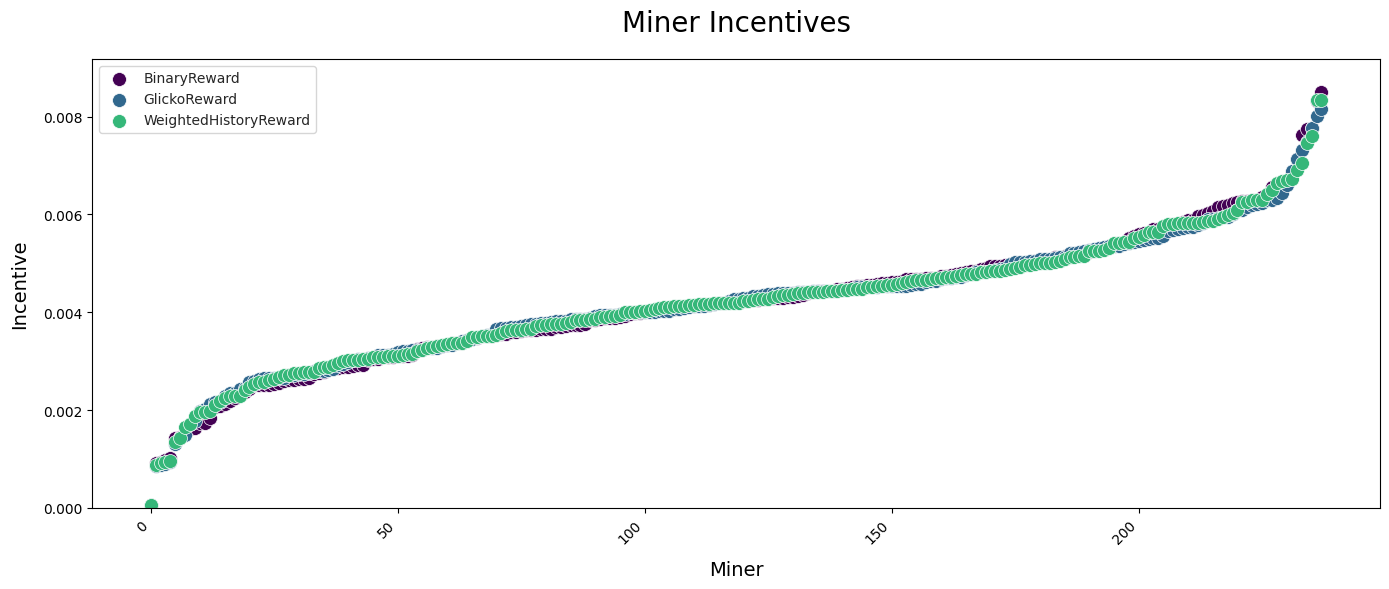

In [27]:
plot_incentives(INCENTIVES)

In [ ]:
plot_incentive_over_time(
    SCORED_DFS, 
    VALIDATOR_UIDS,
    reward_column='weights_BinaryReward', 
    netuid=34,
    highlight_uids=[0,95,100,105])

In [ ]:

plot_incentive_over_time(
    SCORED_DFS, 
    VALIDATOR_UIDS,
    reward_column='weights_GlickoReward', 
    netuid=34,
    highlight_uids=[0,95,100,105])